<a href="https://colab.research.google.com/github/lyhue1991/zztest/blob/master/test_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 5,246,977
Trainable params: 5,246,977
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
313/313 [==============================] - 11s 34ms/step - loss: 0.5382 - acc: 0.7307 - val_loss: 0.3808 - val_acc: 0.8700
Epoch 2/5
313/313 [==============================] - 10s 32ms/step - loss: 0.4685 - acc: 0.7755 - val_loss: 0.4154 - val_acc: 0.8135
Epoch 3/5
313/313 [==============================] - 10s 32ms/step - loss: 0.4707 - acc: 0.7718 - val_loss: 0.4723 - val_acc: 0.8031
Epoch 4/5
313/313 [==============================] - 11s 34ms/step - loss: 0.4513 - acc: 0.7967 - val_loss: 0.4059 - val_acc: 0.8199
Epoch 5/5
313/313 [==============================] - 10s 32ms/step - loss: 0.4528 - acc: 0.7880 - val_loss: 0.2051 - val_acc: 0.9430

used time: 51.996280908584595 



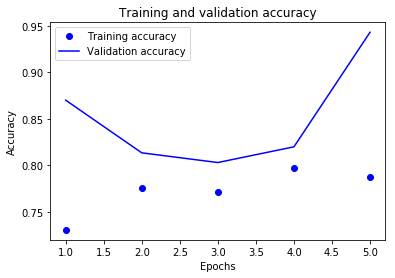

Found 2000 images belonging to 2 classes.
test auc: 0.91235


In [7]:
# coding=utf-8
from __future__ import print_function
from __future__ import division

__author__ = 'Python_Ai_Road'

# ======================================================================
# 〇，设置gpu使用量控制

import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #有多个GPU时可以指定只使用第几号GPU
config = tf.ConfigProto()
config.allow_soft_placement=True #允许动态放置张量和操作符
config.gpu_options.per_process_gpu_memory_fraction = 0.4 #最多使用40%GPU内存
config.gpu_options.allow_growth=True   #初始化时不全部占满GPU显存, 按需分配 
sess = tf.Session(config = config)
set_session(sess)


# ======================================================================
# 一，准备数据

from keras.preprocessing.image import ImageDataGenerator

train_dir =  'cifar2_datasets/train'
test_dir = 'cifar2_datasets/test'

# 对训练集数据设置数据增强
train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

# 对测试集数据无需使用数据增强
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(32, 32),
                    batch_size=32,
                    shuffle = True,
                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size=(32, 32),
                    batch_size=32,
                    shuffle = False,
                    class_mode='binary')

# ======================================================================
# 二，构建模型

from keras import models,layers,optimizers
from keras import backend as K

K.clear_session()
model = models.Sequential()
model.add(layers.Flatten(input_shape = (32,32,3)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

model.summary()

# ======================================================================
# 三，训练模型

# 计算每轮次需要的步数 
import numpy as np 
train_steps_per_epoch  = np.ceil(10000/32)
test_steps_per_epoch  = np.ceil(2000/32)

import time
tic = time.time()
# 使用内存友好的fit_generator方法进行训练
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_steps_per_epoch,
        epochs = 5,
        validation_data= test_generator,
        validation_steps=test_steps_per_epoch,
        workers=6,
        use_multiprocessing=True #linux上可使用多进程读取数据
        )
toc = time.time()

print('\nused time:',toc - tic,'\n')


# ======================================================================
# 四，评估模型
import pandas as pd 
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'png'

dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'
dfhistory.to_csv('hitory_metrics',sep = '\t')


acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ======================================================================
# 五，使用模型

from sklearn.metrics import roc_auc_score

test_datagen = ImageDataGenerator(rescale=1./255)

# 注意，使用模型进行预测时要设置生成器shuffle = False
test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=(32, 32),
                 batch_size=32,
                 class_mode='binary',
                 shuffle = False)

# 计算auc
y_pred = model.predict_generator(test_generator,steps = len(test_generator))
y_pred = np.reshape(y_pred,(-1,))
y_true = np.concatenate([test_generator[i][1] 
                         for i in range(len(test_generator))])
auc = roc_auc_score(y_true,y_pred)

print('test auc:', auc)

# ======================================================================
# 六，保存模型

model.save('cifar2_model.h5')

######
#####
####
###
##
#


In [4]:
import keras 
import tensorflow as tf


(x_train,y_train),(x_test,y_test) = keras.datasets.boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [0]:
import pandas as pd 